### ECON5140 Homework 2
#### Part 2

Helen Dong

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import sklearn.metrics as sk
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed
np.random.seed(42)

##### Problem 1: Comprehensive Time Series Forecasting

In [3]:
print("\n" + "=" * 70)
print("DATASET 1: Monthly Retail Sales")
print("=" * 70)

# Create 4 years of monthly data
dates = pd.date_range('2021-01-01', '2024-12-31', freq='MS')
n_months = len(dates)
t = np.arange(n_months)

# Components
trend = 1000 + 15*t  # Growing business
yearly_seasonal = 300 * np.sin(2*np.pi*t/12) + 200 * np.cos(2*np.pi*t/12)

# Holiday effects (November-December spike)
holiday_effect = np.zeros(n_months)
for year in range(4):
    nov_idx = year*12 + 10  # November
    dec_idx = year*12 + 11  # December
    if nov_idx < n_months:
        holiday_effect[nov_idx] = 400
    if dec_idx < n_months:
        holiday_effect[dec_idx] = 600

# Random noise
noise = np.random.normal(0, 80, n_months)

# Combine
sales = trend + yearly_seasonal + holiday_effect + noise
sales = np.maximum(sales, 0)

# Create DataFrame
df_sales = pd.DataFrame({
    'Date': dates,
    'Sales': sales,
    'Month': dates.month,
    'Year': dates.year,
    'Time': t
})
df_sales.set_index('Date', inplace=True)

print(f"Date range: {df_sales.index[0].date()} to {df_sales.index[-1].date()}")
print(f"Number of months: {len(df_sales)}")
print(f"\nSales Statistics:")
print(df_sales['Sales'].describe())


DATASET 1: Monthly Retail Sales
Date range: 2021-01-01 to 2024-12-01
Number of months: 48

Sales Statistics:
count      48.000000
mean     1419.409544
std       352.878551
min       722.634428
25%      1196.284168
50%      1393.908200
75%      1710.667034
max      2412.774859
Name: Sales, dtype: float64


##### Part A: Regression and ETS Models
##### A1: Time Series Visualization

In [4]:
# borrowing time series plotting function from lesson 2 demo
# slight adjustment, allowing for "values" input

def simple_time_plot(series, values, title, ylabel=None, figsize=(12, 5)):
    """
    Simple function to plot a time series.
    
    Parameters:
    - series: pandas Series with datetime index
    - title: plot title (string)
    - ylabel: y-axis label (string, optional)
    - figsize: figure size tuple (default: (12, 5))
    
    Returns:
    - fig, ax: matplotlib figure and axis objects
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(series.index, values, linewidth=2)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel if ylabel else 'Value')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig, ax

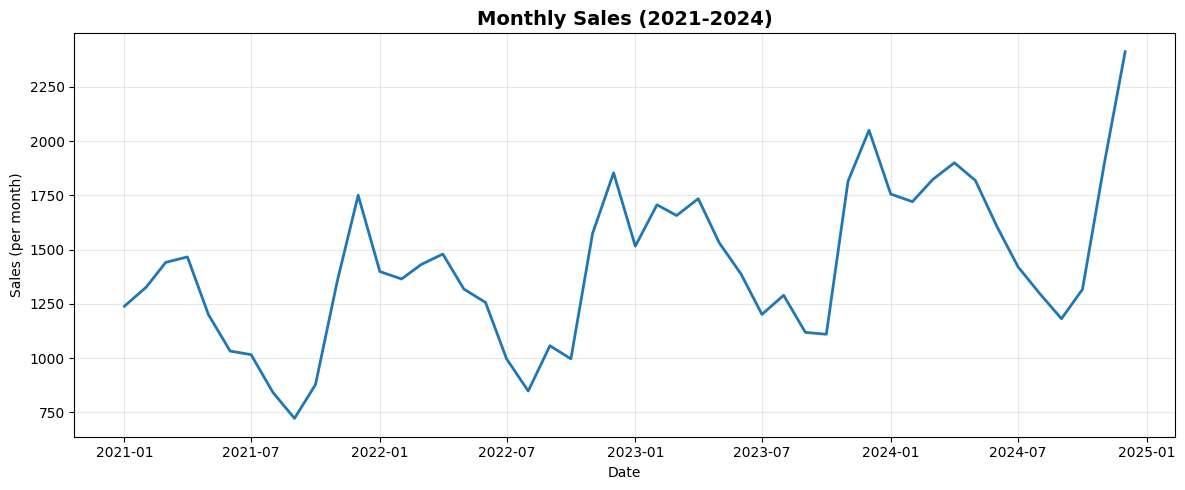

In [5]:
# plot time series using the helper function

fig, ax = simple_time_plot(df_sales, df_sales['Sales'], "Monthly Sales (2021-2024)", ylabel = "Sales (per month)")
plt.show()

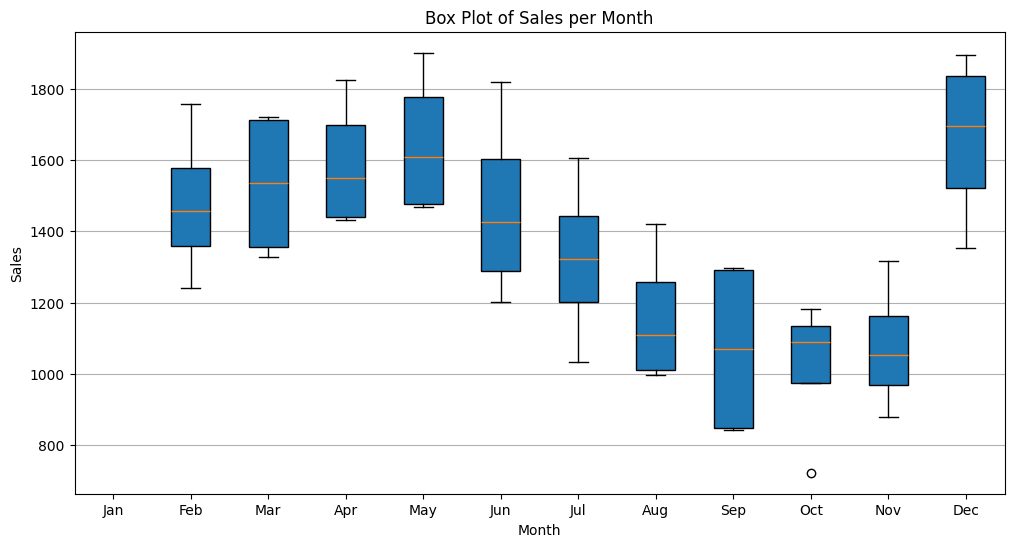

In [6]:
# box plot of sales by month

# reformat data to make it work with boxplot function
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
forbox = [df_sales[df_sales['Month'] == m]['Sales'].dropna().tolist() for m in range(0,12)]

plt.figure(figsize=(12, 6))
plt.boxplot(forbox, labels = month_names, vert=True, patch_artist=True)
plt.title('Box Plot of Sales per Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True, axis='y')
plt.show()

In [7]:
# decomposing to trend (12-month moving average) and detrended (original - trend) series

df_sales['Trend'] = df_sales['Sales'].rolling(window=12, center=True).mean()
df_sales['Detrended'] = df_sales['Sales'] - df_sales['Trend']

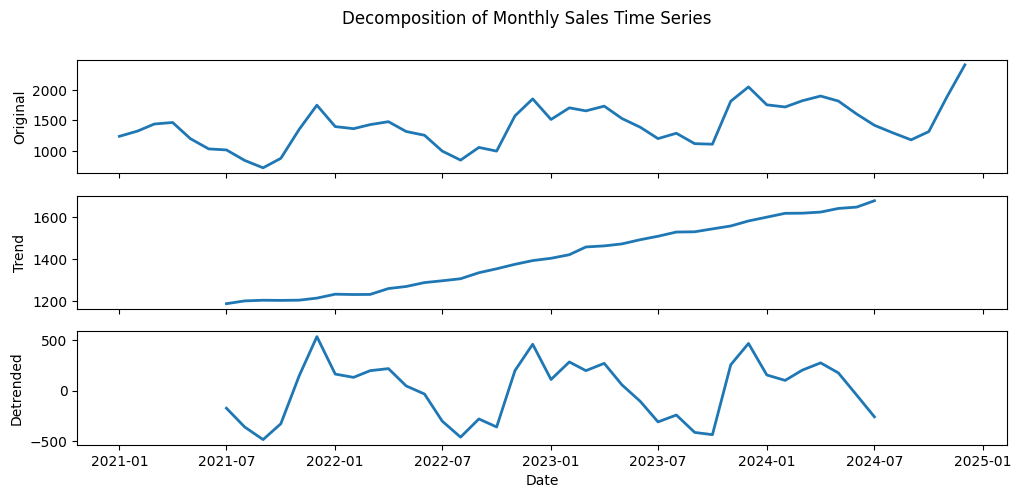

In [8]:
# plot in one figure

fig, axs = plt.subplots(
    3, 1,
    figsize=(12, 5),
    sharex=True
    )
fig.suptitle("Decomposition of Monthly Sales Time Series")

axs[0].plot(df_sales.index, df_sales['Sales'], linewidth=2)
axs[0].set_ylabel("Original")
axs[1].plot(df_sales.index, df_sales['Trend'], linewidth=2)
axs[1].set_ylabel("Trend")
axs[2].plot(df_sales.index, df_sales['Detrended'], linewidth=2)
axs[2].set_ylabel("Detrended")
axs[2].set_xlabel("Date")
plt.show()

##### A2: Linear Regression with Trend and Seasonality

In [9]:
# split data into test and training sets

max_date = df_sales.index.max()
test_start = max_date - pd.Timedelta(days=180)

train_end = test_start - pd.Timedelta(days=1)

train = df_sales.loc[:train_end].copy()
test = df_sales.loc[test_start:].copy()

print(f"Training set: {train.index.min()} to {train.index.max()}")
print(f"  Number of observations: {len(train)}")
print(f"\nTest set: {test.index.min()} to {test.index.max()}")
print(f"  Number of observations: {len(test)}")
print(f"\nTraining set covers {len(train)/len(df_sales)*100:.1f}% of data")
print(f"Test set covers {len(test)/len(df_sales)*100:.1f}% of data")

Training set: 2021-01-01 00:00:00 to 2024-06-01 00:00:00
  Number of observations: 42

Test set: 2024-07-01 00:00:00 to 2024-12-01 00:00:00
  Number of observations: 6

Training set covers 87.5% of data
Test set covers 12.5% of data


In [10]:
# dataset seems too small to split into training and test sets like that, i will just fit the model using the entire set
# create seasonal dummy variables

dummies = pd.get_dummies(df_sales['Month'], drop_first=True)

In [11]:
# set dependent and independent variables and add constant

y = df_sales['Sales']
x = pd.concat([df_sales['Time'], dummies], axis=1)

x = sm.add_constant(x)

In [12]:
# fit OLS regression model

model = sm.OLS(y, x.astype(float)).fit()

In [13]:
# regression summary

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     83.27
Date:                Wed, 11 Feb 2026   Prob (F-statistic):           4.66e-22
Time:                        19:43:33   Log-Likelihood:                -267.91
No. Observations:                  48   AIC:                             561.8
Df Residuals:                      35   BIC:                             586.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1225.9156     40.334     30.394      0.000    1144.033    1307.798
Time          14.0082      0.809     17.310      0.000      12.365      15.651
2             38.1279     53.197      0.717      0.478     -69.868     146.124
3             82.5999     53.216      1.552      0.130     -25.434     190.633
4            125.5783     53.246      2.358      0.024      17.482     233.674
5            -66.4715     53.289     -1.247      0.221    -174.655      41.712
6           -227.1135     53.345     -4.257      0.000    -335.409    -118.818
7           -403.0357     53.412     -7.546      0.000    -511.468    -294.603
8           -506.1995     53.492     -9.463      0.000    -614.794    -397.605
9           -569.8533     53.584    -10.635      0.000    -678.634    -461.073
10          -528.3524     53.687     -9.841      0.000    -637.343    -419.361
11            41.3676     53.803      0.769      0.447     -67.859     150.594
12           384.9678     53.931      7.138      0.000     275.483     494.453
==============================================================================
Omnibus:                        1.898   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.387   Jarque-Bera (JB):                1.811
Skew:                           0.443   Prob(JB):                        0.404
Kurtosis:                       2.654   Cond. No.                         341.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The monthly trend ($\beta$1) is 14.0082, which indicates that sales tend to trend upwards as the year goes on (e.g. sales in February are generally higher than sales in January by a factor of 14).

From the coefficients, it looks like September sees the largest negative seasonal effect (-569.85) while December sees the largest positive seasonal effect (384.97).

Based on the p-values, most of the coefficients are significant, with the exceptions of the coefficients for dummy variables of months 2, 3, 5, and 11. This is based on a significance value of 0.05.

In [14]:
# get fitted values based on training set

y_fitted = model.fittedvalues

In [15]:
# calculate R^2, RMSE, and MAE based on the model and the fitted values

r2 = model.rsquared
rmse = np.sqrt(sk.mean_squared_error(y, y_fitted))
mae = sk.mean_absolute_error(y, y_fitted)

In [16]:
print(f"R^2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R^2: 0.9661603639543462
RMSE: 64.23421385166395
MAE: 50.75630554682849


##### A3: Fourier Terms for Seasonality

In [17]:
# generate fourier terms

# 48 months of data means 48 times
t = np.arange(0, 48)
big_t = 12
k = 2

f_terms = {}
for k in range(1, k+1):
    f_terms[f'sin_{k}'] = np.sin(2 * np.pi * k * t / big_t)
    f_terms[f'cos_{k}'] = np.cos(2 * np.pi * k * t / big_t)

fourier_terms = pd.DataFrame(f_terms, index=df_sales.index)

In [18]:
# set up for regression model fitting

y = df_sales['Sales']
x = pd.concat([df_sales['Time'], fourier_terms], axis=1)

x = sm.add_constant(x)

In [19]:
# fit model

fourier_model = sm.OLS(y, x.astype(float)).fit()

In [20]:
fourier_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     52.94
Date:                Wed, 11 Feb 2026   Prob (F-statistic):           4.72e-17
Time:                        19:43:48   Log-Likelihood:                -301.46
No. Observations:                  48   AIC:                             614.9
Df Residuals:                      42   BIC:                             626.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1070.5202     40.011     26.755      0.000     989.774    1151.267
Time          14.8464      1.476     10.058      0.000      11.867      17.825
sin_1        185.0786     28.731      6.442      0.000     127.097     243.060
cos_1        298.2817     28.237     10.564      0.000     241.298     355.265
sin_2       -155.5984     28.314     -5.496      0.000    -212.738     -98.459
cos_2         17.6395     28.237      0.625      0.536     -39.344      74.623
==============================================================================
Omnibus:                        0.579   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.748   Jarque-Bera (JB):                0.690
Skew:                           0.225   Prob(JB):                        0.708
Kurtosis:                       2.624   Cond. No.                         55.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
print("Comparing Dummy Variable and Fourier Models")
print(f"R^2\n Dummy Variable: {model.rsquared}\n Fourier: {fourier_model.rsquared}")
print(f"AIC\n Dummy Variable: {model.aic}\n Fourier: {fourier_model.aic}")
print(f"Number of Parameters\n Dummy Variable: {len(model.params)}\n Fourier: {len(fourier_model.params)}")

Comparing Dummy Variable and Fourier Models
R^2
 Dummy Variable: 0.9661603639543462
 Fourier: 0.8630541714267048
AIC
 Dummy Variable: 561.8215546864946
 Fourier: 614.9232821855522
Number of Parameters
 Dummy Variable: 13
 Fourier: 6


Overall, it looks to me like the Fourier model is preferable for prediction due to the lower AIC and lower number of parameters. While the dummy variable model comes out with a higher R^2, that might be due to overfitting considering the high number of parameters. Besides, the Fourier model also has a respectably high R^2 and R^2 isn't the best metric for measuring the better predictive model.

In [22]:
# get fourier model's fitted values

fourier_fitted = fourier_model.fittedvalues

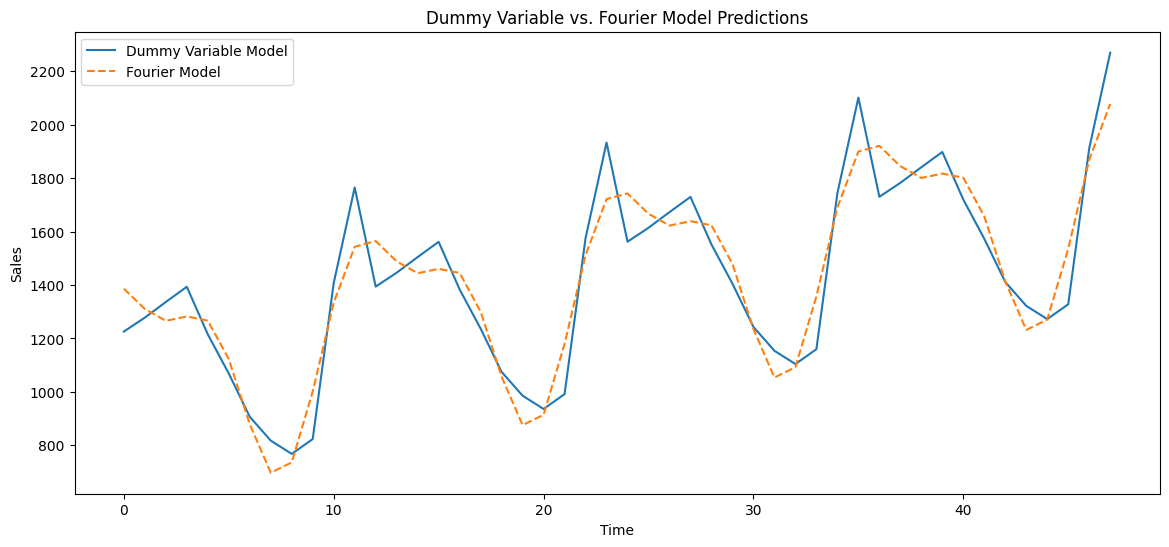

In [23]:
# plot fitted values of both dummy variable and fourier models

plt.figure(figsize=(14, 6))
plt.plot(df_sales['Time'], y_fitted, label='Dummy Variable Model')
plt.plot(df_sales['Time'], fourier_fitted, label='Fourier Model', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Dummy Variable vs. Fourier Model Predictions')
plt.legend()
plt.show()

I prefer the Fourier approach because it looks like the fitted values are on a much smoother curve, which suggests that it ignores "noise" in the data and captures the broader, underlying seasonal patterns as opposed to the dummy variable model's curve, which has more dramatic spikes.

##### A4: Simple Exponential Smoothing (SES)

In [24]:
# split data into test and training sets
# first 36 months for training

max_date = df_sales.index.max()
test_start = max_date - pd.Timedelta(days=365)

train_end = test_start - pd.Timedelta(days=1)

train = df_sales.loc[:train_end].copy()
test = df_sales.loc[test_start:].copy()

print(f"Training set: {train.index.min()} to {train.index.max()}")
print(f"  Number of observations: {len(train)}")
print(f"\nTest set: {test.index.min()} to {test.index.max()}")
print(f"  Number of observations: {len(test)}")
print(f"\nTraining set covers {len(train)/len(df_sales)*100:.1f}% of data")
print(f"Test set covers {len(test)/len(df_sales)*100:.1f}% of data")

Training set: 2021-01-01 00:00:00 to 2023-12-01 00:00:00
  Number of observations: 36

Test set: 2024-01-01 00:00:00 to 2024-12-01 00:00:00
  Number of observations: 12

Training set covers 75.0% of data
Test set covers 25.0% of data


In [25]:
# get monthly averages for the training set

monthly_averages = train.groupby('Month')['Sales'].mean()

In [26]:
# map averages and deseasonalize sales

train['Seasonal Average'] = train['Month'].map(monthly_averages)
train['Deseasonalized Sales'] = train['Sales'] - train['Seasonal Average']

In [27]:
# fit SES model and let it optimize itself

ses_model = SimpleExpSmoothing(train['Sales'])
ses_fitted = ses_model.fit(optimized=True)

In [28]:
# print optimized alpha

print(f"Alpha = {ses_fitted.params['smoothing_level']}")

Alpha = 0.9999999850988388


This high alpha value tells me that the model places 99.9% weight on the most recent observation and is highly responsive to sudden shifts in the data.

In [29]:
# forecast on the test data

ses_forecast = ses_fitted.forecast(len(test))

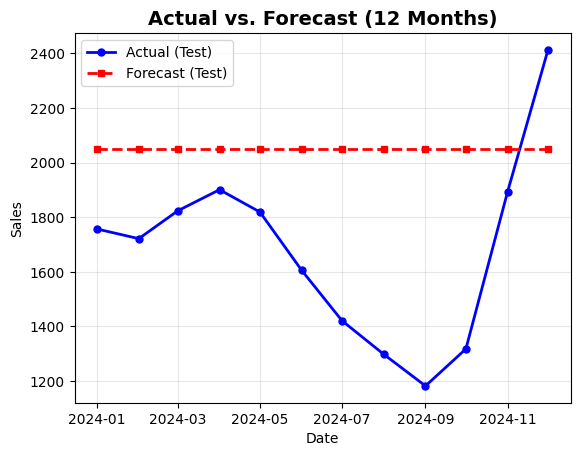

In [66]:
# visualize the forecast vs. the actual test data

plt.plot(test.index, test['Sales'], label='Actual (Test)', linewidth=2, marker='o', markersize=5, color='blue')
plt.plot(test.index, ses_forecast, label='Forecast (Test)', linewidth=2, marker='s', markersize=5, color='red', linestyle='--')
plt.title('Actual vs. Forecast (12 Months)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [31]:
# add seasonality back into forecast

s_forecast = {}

for i in range(len(ses_forecast)):
    s_forecast[i] = ses_forecast[i] + monthly_averages[i+1]

seasoned_forecast = pd.DataFrame(s_forecast.values(), columns=['Forecast'], index=ses_forecast.index)

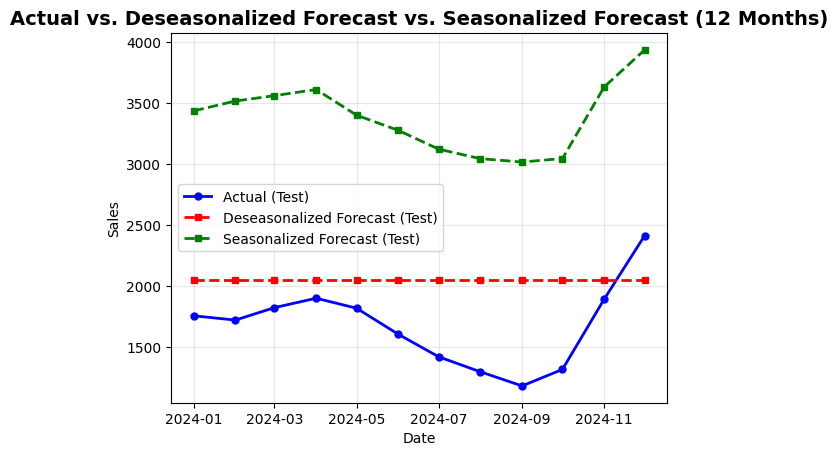

In [65]:
# visualize the deseasonalized forecast vs. the seasoned forecast vs. the actual test data

plt.plot(test.index, test['Sales'], label='Actual (Test)', linewidth=2, marker='o', markersize=5, color='blue')
plt.plot(test.index, ses_forecast, label='Deseasonalized Forecast (Test)', linewidth=2, marker='s', markersize=5, color='red', linestyle='--')
plt.plot(test.index, seasoned_forecast, label='Seasonalized Forecast (Test)', linewidth=2, marker='s', markersize=5, color='green', linestyle='--')
plt.title('Actual vs. Deseasonalized Forecast vs. Seasonalized Forecast (12 Months)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [71]:
# check forecast accuracy with seasonalized forecast against actual test values

ses_mse = sk.mean_squared_error(test['Sales'], seasoned_forecast)
ses_rmse = np.sqrt(mse)
ses_mae = sk.mean_absolute_error(test['Sales'], seasoned_forecast)

In [34]:
print("Checking SES forecast accuracy:\n")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

Checking SES forecast accuracy:

MSE: 2910642.3243151004
RMSE: 1706.0604691261974
MAE: 1704.1141439571193


We can see from the graph as well, but the forecast is an average of around 1740 sales higher than the actual sales data.

##### A5: Holt's Linear Trend Method

In [42]:
# fit holt's linear trend model with deseasonalized sales

holt_model = ExponentialSmoothing(train['Deseasonalized Sales'], trend='add', seasonal=None).fit()

In [47]:
print("Optimized parameters\n")
print(f"Alpha (level smoothing): {holt_model.params['smoothing_level']}")
print(f"Beta (trend smoothing): {holt_model.params['smoothing_trend']}")

Optimized parameters

Alpha (level smoothing): 0.2200930255111523
Beta (trend smoothing): 0.0


In [49]:
# get final state level and trend

final_level = holt_model.level[-1]
final_trend = holt_model.trend[-1]

print(f"Final level: {final_level}")
print(f"Final trend: {final_trend}")

Final level: 206.348482843172
Final trend: 10.557094940720107


In [50]:
# forecast next 12 months

holt_forecast = holt_model.forecast(steps=len(test))

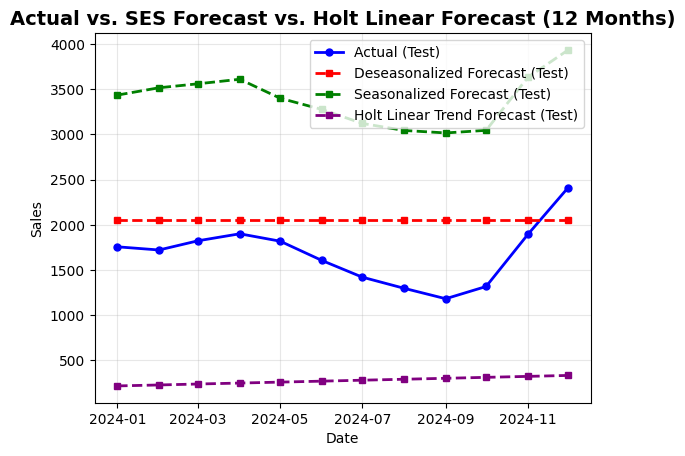

In [64]:
# visualize holt forecast alongside both ses forecasts (deseasonalized and seasonalize) and the actual data

plt.plot(test.index, test['Sales'], label='Actual (Test)', linewidth=2, marker='o', markersize=5, color='blue')
plt.plot(test.index, ses_forecast, label='Deseasonalized Forecast (Test)', linewidth=2, marker='s', markersize=5, color='red', linestyle='--')
plt.plot(test.index, seasoned_forecast, label='Seasonalized Forecast (Test)', linewidth=2, marker='s', markersize=5, color='green', linestyle='--')
plt.plot(test.index, holt_forecast, label='Holt Linear Trend Forecast (Test)', linewidth=2, marker='s', markersize=5, color='purple', linestyle='--')
plt.title('Actual vs. SES Forecast vs. Holt Linear Forecast (12 Months)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The seasonalized SES forecast captures the trend best, but between the two models that were trained on deseasonalized sales data, Holt performed better.

##### A6: Holt-Winters Seasonal Method

In [54]:
# fit holt-winters model using regular training data

hw_model = ExponentialSmoothing(train['Sales'], trend='add', seasonal='add', seasonal_periods=12).fit()

In [56]:
print("Optimized parameters\n")
print(f"Alpha (level smoothing): {hw_model.params['smoothing_level']}")
print(f"Beta (trend smoothing): {hw_model.params['smoothing_trend']}")
print(f"Gamma (seasonal smoothing): {hw_model.params['smoothing_seasonal']}")

Optimized parameters

Alpha (level smoothing): 0.16944286516500662
Beta (trend smoothing): 0.16944286516500662
Gamma (seasonal smoothing): 0.0


In [60]:
# extract components of holt winters model

hw_level = hw_model.level
hw_trend = hw_model.trend
hw_seasonal = hw_model.season

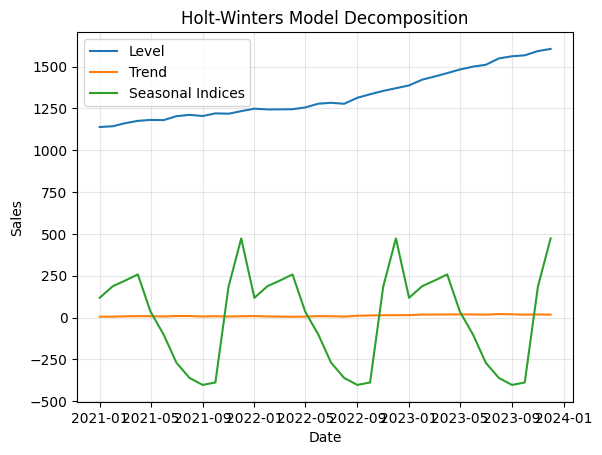

In [69]:
plt.plot(hw_level, label="Level")
plt.plot(hw_trend, label="Trend")
plt.plot(hw_seasonal, label="Seasonal Indices")
plt.title("Holt-Winters Model Decomposition")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [70]:
# generate 12 month forecast

hw_forecast = hw_model.forecast(steps=len(test))

In [74]:
# to check forecast accuracy using metrics mse, rmse, and mae
# calculate values for holt linear and holt winters
# and mse for regression model

mse = sk.mean_squared_error(y, y_fitted)
h_mse = sk.mean_squared_error(test['Sales'], holt_forecast)
h_rmse = np.sqrt(h_mse)
h_mae = sk.mean_absolute_error(test['Sales'], holt_forecast)
hw_mse = sk.mean_squared_error(test['Sales'], hw_forecast)
hw_rmse = np.sqrt(hw_mse)
hw_mae = sk.mean_absolute_error(test['Sales'], hw_forecast)

In [75]:
# compare using a table

accuracy_comp = pd.DataFrame()

In [76]:
# add values

accuracy_comp['Model'] = ['Regression', 'SES', 'Holt', 'Holt-Winters']
accuracy_comp['MSE'] = [mse, ses_mse, h_mse, hw_mse]
accuracy_comp['RMSE'] = [rmse, ses_rmse, h_rmse, hw_rmse]
accuracy_comp['MAE'] = [mae, ses_mae, h_mae, hw_mae]
accuracy_comp.set_index('Model')

,MSE,RMSE,MAE
Model,,,
Regression,4.126034e+03,1706.060469,1704.114144
SES,2.910642e+06,1706.060469,1704.114144
Holt,2.079805e+06,1442.152820,1404.257525
Holt-Winters,7.836494e+03,88.523974,74.694967


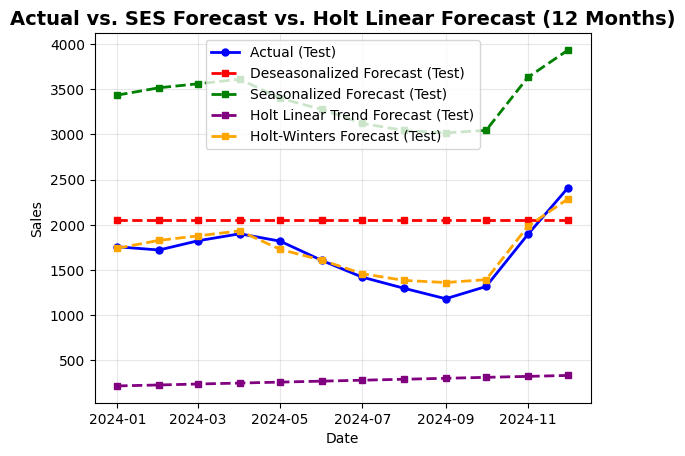

In [79]:
# visualize all forecasts

plt.plot(test.index, test['Sales'], label='Actual (Test)', linewidth=2, marker='o', markersize=5, color='blue')
plt.plot(test.index, ses_forecast, label='Deseasonalized Forecast (Test)', linewidth=2, marker='s', markersize=5, color='red', linestyle='--')
plt.plot(test.index, seasoned_forecast, label='Seasonalized Forecast (Test)', linewidth=2, marker='s', markersize=5, color='green', linestyle='--')
plt.plot(test.index, holt_forecast, label='Holt Linear Trend Forecast (Test)', linewidth=2, marker='s', markersize=5, color='purple', linestyle='--')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast (Test)', linewidth=2, marker='s', markersize=5, color='orange', linestyle='--')
plt.title('Actual vs. SES Forecast vs. Holt Linear Forecast (12 Months)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Based on both the metrics and the visualization, the Holt-Winters method produced the best and most accurate forecast by far, with a much lower RMSE and MAE than the other models and a forecast curve that almost directly mirrors the actual data.

##### Part B: ARIMA Models

In [164]:
print("\n" + "=" * 70)
print("DATASET 2: Daily Stock Returns")
print("=" * 70)

# Create 500 days of stock price data
n_days = 500
dates_stock = pd.date_range('2023-01-01', periods=n_days, freq='D')

# Generate AR(1) returns with some volatility clustering
returns = np.zeros(n_days)
returns[0] = np.random.normal(0, 0.01)

phi = 0.05  # Small autocorrelation in returns
for i in range(1, n_days):
    returns[i] = phi * returns[i-1] + np.random.normal(0, 0.015)

# Calculate price from returns (starting at 100)
price = 100 * np.exp(np.cumsum(returns))

df_stock = pd.DataFrame({
    'Date': dates_stock,
    'Price': price,
    'Returns': returns * 100  # Convert to percentage
})
df_stock.set_index('Date', inplace=True)

print(f"Date range: {df_stock.index[0].date()} to {df_stock.index[-1].date()}")
print(f"Number of days: {len(df_stock)}")
print(f"\nPrice Statistics:")
print(df_stock['Price'].describe())


DATASET 2: Daily Stock Returns
Date range: 2023-01-01 to 2024-05-14
Number of days: 500

Price Statistics:
count    500.000000
mean     125.533859
std       29.828195
min       88.889863
25%      103.131075
50%      110.437569
75%      156.211554
max      198.835896
Name: Price, dtype: float64


##### B1: Stationarity Testing

In [81]:
# get rolling mean and std for plotting

df_stock['30-Day Mean'] = df_stock['Price'].rolling(window=12, center=True).mean()
df_stock['30-Day STD'] = df_stock['Price'].rolling(window=12, center=True).std()

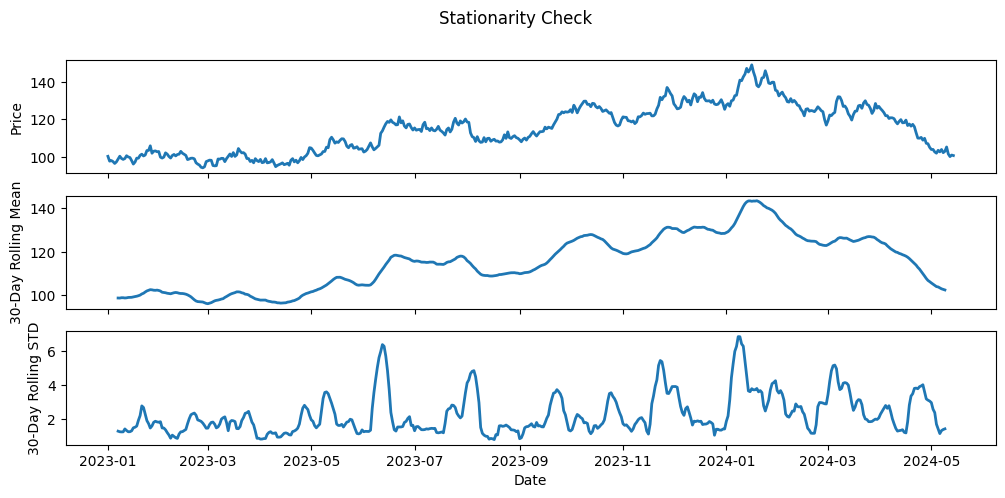

In [83]:
fig, axs = plt.subplots(
    3, 1,
    figsize=(12, 5),
    sharex=True
    )
fig.suptitle("Stationarity Check")

axs[0].plot(df_stock.index, df_stock['Price'], linewidth=2)
axs[0].set_ylabel("Price")
axs[1].plot(df_stock.index, df_stock['30-Day Mean'], linewidth=2)
axs[1].set_ylabel("30-Day Rolling Mean")
axs[2].plot(df_stock.index, df_stock['30-Day STD'], linewidth=2)
axs[2].set_ylabel("30-Day Rolling STD")
axs[2].set_xlabel("Date")
plt.show()

From these graphs, it looks like price is not stationary, since there is an obvious upwards trend in the first 3/4 of the data and then a downwards trend.

In [86]:
# ADF stationarity test

adf_result = adfuller(df_stock['Price'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Decision at α = 0.05
if adf_result[1] < 0.05:
    print("Decision: Reject the Null Hypothesis (Data is Stationary)")
else:
    print("Decision: Fail to Reject the Null Hypothesis (Data is Non-Stationary)")

ADF Statistic: -1.5185387907145633
p-value: 0.5243213458211365
Decision: Fail to Reject the Null Hypothesis (Data is Non-Stationary)


In [87]:
# KPSS stationarity test

kpss_result = kpss(df_stock['Price'], regression='c')

print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')

# Decision at α = 0.05
if kpss_result[1] < 0.05:
    print("Decision: Reject the Null Hypothesis (Data is Non-Stationary)")
else:
    print("Decision: Fail to Reject the Null Hypothesis (Data is Stationary)")

KPSS Statistic: 2.5617862074737974
p-value: 0.01
Decision: Reject the Null Hypothesis (Data is Non-Stationary)


The ADF and KPSS tests both conclude that the data is non-stationary.

##### B2: First Differencing

In [88]:
# calculate first differences

diff_price = df_stock['Price'].diff()

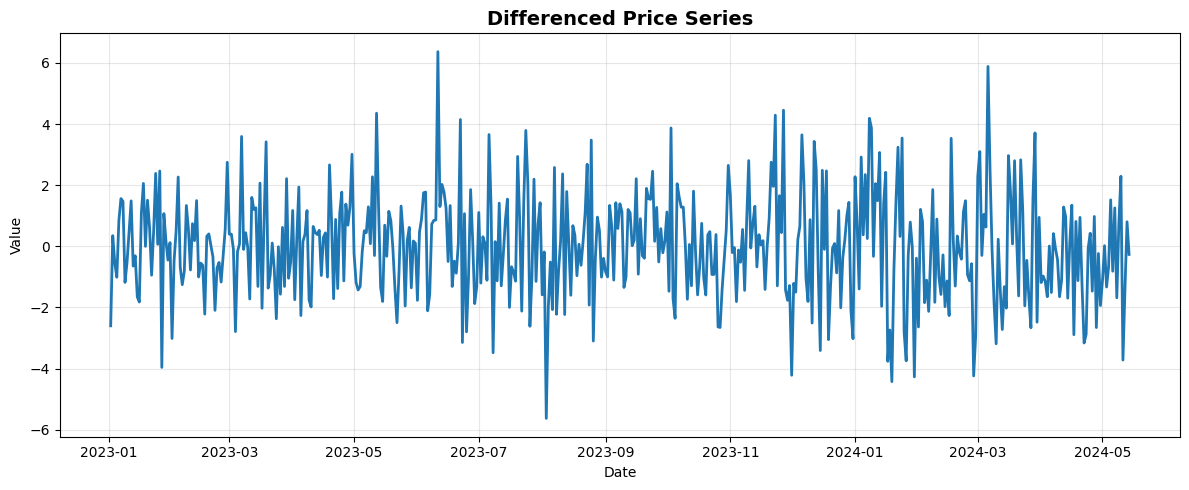

In [93]:
# plot it

fig, ax = simple_time_plot(diff_price, diff_price, 'Differenced Price Series', ylabel=None, figsize=(12, 5))
plt.show()

In [95]:
# run ADF on differenced price series

diff_adf = adfuller(diff_price.dropna())

print(f'ADF Statistic: {diff_adf[0]}')
print(f'p-value: {diff_adf[1]}')

if diff_adf[1] < 0.05:
    print("Decision: Reject the Null Hypothesis (Data is Stationary)")
else:
    print("Decision: Fail to Reject the Null Hypothesis (Data is Non-Stationary)")

ADF Statistic: -21.40862857507443
p-value: 0.0
Decision: Reject the Null Hypothesis (Data is Stationary)


After first differencing, the data is now stationary according to the ADF test.

In [96]:
# calculate correlation between returns and diff_price

corr_value = df_stock['Returns'].corr(diff_price)
print(f"Correlation between returns and difference price: {corr_value}")

Correlation between returns and difference price: 0.9937385243812944


With a correlation value of 0.99, it looks like returns and the difference prices are highly correlated (almost exactly).

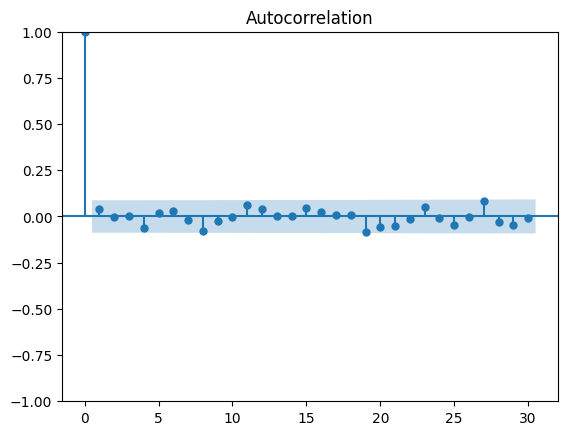

In [102]:
# plot ACF of differenced prices

plot_acf(diff_price.dropna(), lags=30).show()

There doesn't seem to be any significant autocorrelation based on this plot except for maybe at lags 8, 19, and 26 where it looks like the correlation is at the upper bounds of the interval.

##### B3: ACF and PACF Analysis

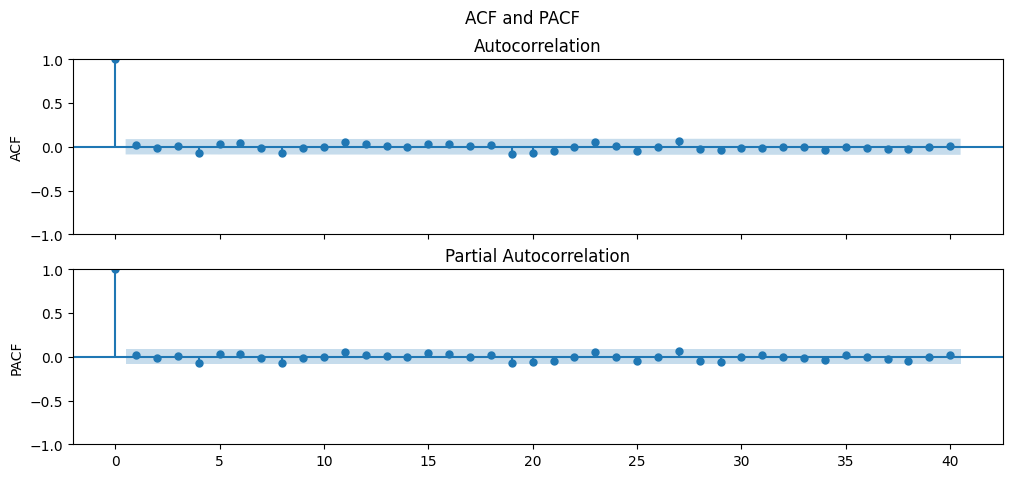

In [104]:
fig, axs = plt.subplots(
    2, 1,
    figsize=(12, 5),
    sharex=True
    )
fig.suptitle("ACF and PACF")

plot_acf(df_stock['Returns'], lags=40, ax=axs[0])
axs[0].set_ylabel("ACF")
plot_pacf(df_stock['Returns'], lags=40, ax=axs[1])
axs[1].set_ylabel("PACF")
plt.show()

There are no significant spikes for either the ACF or PACF plots. Rather than a gradual decay, both plots exhibit a sharp drop/cut off.

These plots suggest that both the AR order (p) and MA order (q) should be 0, since there's no signs of autocorrelation and a random walk model would likely be the best fit.

In [105]:
# calculate specific autocorrelations manually

lag1 = df_stock['Returns'].autocorr(lag=1)
lag5 = df_stock['Returns'].autocorr(lag=5)

print(f"Autocorrelation lag 1: {lag1}")
print(f"Autocorrelation lag 5: {lag5}")

Autocorrelation lag 1: 0.023787313738389524
Autocorrelation lag 5: 0.027253789017448685


##### B4: AR Model Estimation

In [107]:
# fit AR(1) model on returns

ar_model = ARIMA(df_stock['Returns'], order=(1, 0, 0)).fit()

In [108]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Returns   No. Observations:                  500
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -902.468
Date:                Wed, 11 Feb 2026   AIC                           1810.936
Time:                        21:01:29   BIC                           1823.579
Sample:                    01-01-2023   HQIC                          1815.897
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.068      0.022      0.983      -0.132       0.135
ar.L1          0.0237      0.046      0.516      0.606      -0.066       0.114
sigma2         2.1641      0.129     16.770      0.000       1.911       2.417
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.21
Prob(Q):                              0.99   Prob(JB):                         0.12
Heteroskedasticity (H):               1.17   Skew:                             0.18
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [109]:
print(f"phi1 coefficient: {ar_model.arparams[0]}")

phi1 coefficient: 0.02374699613227081


From the summary table, we see that the p-value for $\phi$1 is 0.606, which is much larger than the significance value 0.05 and therefore shows that this coefficient is not significant.

Since $\phi$1 is positive, it suggests that the series experiences positive autocorrelation. However, since the coefficient is so small and the p-value suggests insignificance, we shouldn't put too much weight on this observation.

Since the absolute value of $\phi$1 is less than 1, the series is stationary.

In [110]:
# fit AR(2) and AR(3)

ar2 = ARIMA(df_stock['Returns'], order=(2, 0, 0)).fit()
ar3 = ARIMA(df_stock['Returns'], order=(3, 0, 0)).fit()

In [111]:
# print AIC values of all three fitted models

print("AIC values\n")
print(f"AR(1): {ar_model.aic}")
print(f"AR(2): {ar2.aic}")
print(f"AR(3): {ar3.aic}")

AIC values

AR(1): 1810.9356538719035
AR(2): 1812.8490019048731
AR(3): 1814.8051888731313


Since a lower AIC indicates a better fit, AR(1) is the preferred model out of these three.

In [115]:
# get residuals for preferred model AR(1)

ar_resid = ar_model.resid

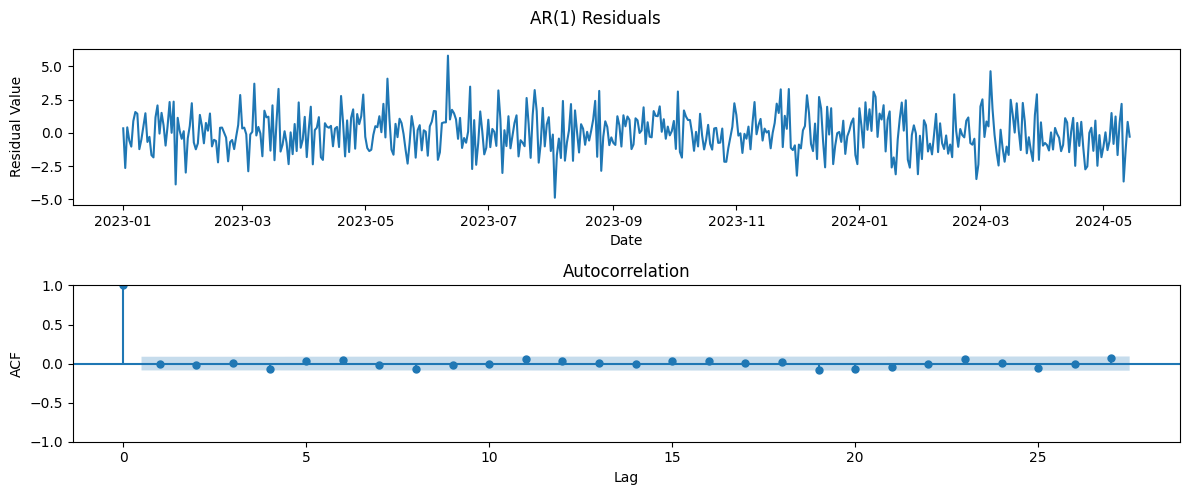

In [128]:
# plot residuals and their ACF

fig, axs = plt.subplots(
    2, 1,
    figsize=(12, 5),
    )
fig.suptitle("AR(1) Residuals")

axs[0].plot(ar_resid)
axs[0].set_ylabel("Residual Value")
axs[0].set_xlabel("Date")
plot_acf(ar_resid, ax=axs[1])
axs[1].set_ylabel("ACF")
axs[1].set_xlabel("Lag")
plt.tight_layout()
plt.show()

The residuals appear to be white noise (no significant autocorrelation spikes and no trends or patterns in the time series plot).

##### B5: MA Model Estimation

In [144]:
# fit MA(1) model on returns

ma1 = ARIMA(df_stock['Returns'], order=(0, 0, 1)).fit()

In [145]:
ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Returns   No. Observations:                  500
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -902.464
Date:                Wed, 11 Feb 2026   AIC                           1810.928
Time:                        22:20:51   BIC                           1823.572
Sample:                    01-01-2023   HQIC                          1815.889
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.068      0.022      0.983      -0.132       0.135
ma.L1          0.0244      0.046      0.530      0.596      -0.066       0.115
sigma2         2.1640      0.129     16.771      0.000       1.911       2.417
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.22
Prob(Q):                              1.00   Prob(JB):                         0.12
Heteroskedasticity (H):               1.17   Skew:                             0.18
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The coefficient is 0.0244 and has a p-value of 0.596, indicating a lack of significance. Since the coefficient is positive, this indicates positive momentum derived from shocks in the previous period (though the the magnitude of the coefficient between close to 0 and the lack of significance both indicate that this momentum, if any, is minimal).

Since the absolute value of the coefficient is less than 1, the model is invertible.

In [125]:
# compare MA(1) and AR(1)

arma_comp = pd.DataFrame()
arma_comp['Model'] = ['MA(1)', 'AR(1)']
arma_comp['AIC'] = [ma1.aic, ar_model.aic]
arma_comp['BIC'] = [ma1.bic, ar_model.bic]
arma_comp['Log-Likelihood'] = [ma1.llf, ar_model.llf]
arma_comp.set_index('Model')

,AIC,BIC,Log-Likelihood
Model,,,
MA(1),1810.928056,1823.571880,-902.464028
AR(1),1810.935654,1823.579478,-902.467827


From these metrics, it's difficult, if not impossible, to determine which model fits better, considering they're almost an exact match for each metric. MA(1) may have a slight (very slight) edge since its metrics are slightly lower.

In [126]:
# residuals for MA(1)

ma_resid = ma1.resid

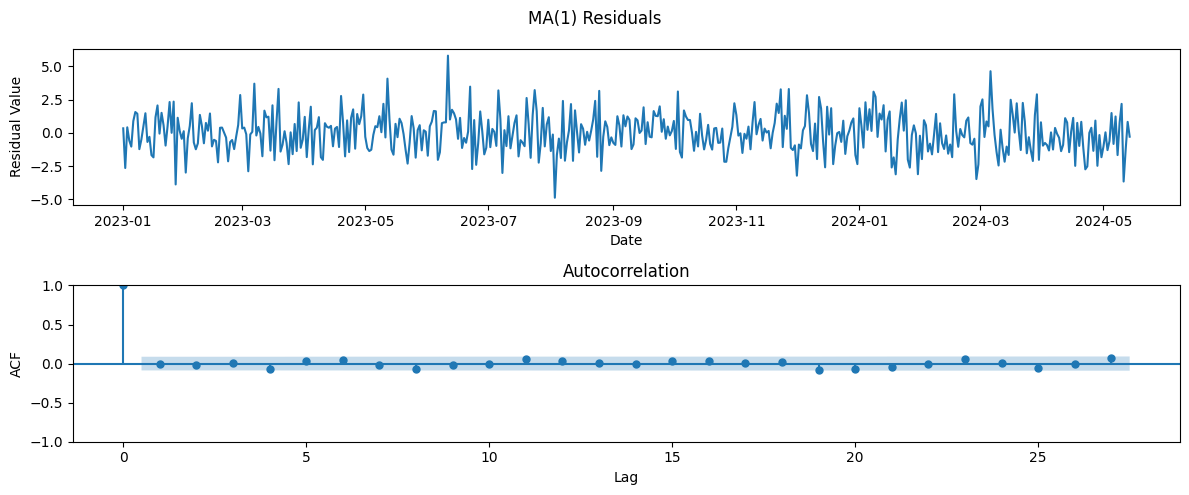

In [127]:
# plot residuals and their ACF

fig, axs = plt.subplots(
    2, 1,
    figsize=(12, 5),
    )
fig.suptitle("MA(1) Residuals")

axs[0].plot(ma_resid)
axs[0].set_ylabel("Residual Value")
axs[0].set_xlabel("Date")
plot_acf(ma_resid, ax=axs[1])
axs[1].set_ylabel("ACF")
axs[1].set_xlabel("Lag")
plt.tight_layout()
plt.show()

Similar to AR(1), MA(1)'s residuals look like white noise, which is good.

##### B6: ARMA(p,q) Model

In [129]:
# fit ARMA(1,1) model on returns

arma1 = ARIMA(df_stock['Returns'], order=(1, 0, 1)).fit()

In [130]:
arma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Returns   No. Observations:                  500
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -901.801
Date:                Wed, 11 Feb 2026   AIC                           1811.602
Time:                        22:10:55   BIC                           1828.461
Sample:                    01-01-2023   HQIC                          1818.217
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.068      0.022      0.982      -0.131       0.134
ar.L1         -0.8346      0.229     -3.651      0.000      -1.283      -0.387
ma.L1          0.8659      0.209      4.141      0.000       0.456       1.276
sigma2         2.1582      0.129     16.759      0.000       1.906       2.411
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.94
Prob(Q):                              0.92   Prob(JB):                         0.08
Heteroskedasticity (H):               1.17   Skew:                             0.19
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [140]:
# add this model's metrics to the comp table we had before

arma_comp.loc[len(arma_comp)] = ['ARMA(1)', arma1.aic, arma1.bic, arma1.llf]
arma_comp.set_index('Model')

,AIC,BIC,Log-Likelihood
Model,,,
MA(1),1810.928056,1823.571880,-902.464028
AR(1),1810.935654,1823.579478,-902.467827
ARMA(1),1811.602199,1828.460631,-901.801099


Considering that ARMA(1) seems to end up with a higher AIC and BIC and a lower log-likelihood, it seems to be the least optimal model so far.

At the same time, however, the coefficients in ARMA(1) are both significant according to their p-values, which makes this situation a lot more confusing to me.

In [147]:
# add parameters to the table

arma_comp['Parameters'] = [ma1.maparams, ar_model.arparams, [arma1.maparams, arma1.arparams]]

In [148]:
arma_comp.set_index('Model')

,AIC,BIC,Log-Likelihood,Parameters
Model,,,,
MA(1),1810.928056,1823.571880,-902.464028,[0.024383227069476057]
AR(1),1810.935654,1823.579478,-902.467827,[0.02374699613227081]
ARMA(1),1811.602199,1828.460631,-901.801099,"[[0.8658703006383298], [-0.8345645974967819]]"


##### B7: Automatic ARIMA

In [153]:
# use auto_arima to find the best model
# min p,q = 0
# max p,q = 5

best_model = pm.auto_arima(df_stock['Returns'], start_p=0, start_q=0, max_p=5, max_q=5, d=0, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1809.218, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1810.936, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1810.928, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1807.219, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1811.602, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.164 seconds


In [154]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                        SARIMAX   Log Likelihood                -902.609
Date:                Wed, 11 Feb 2026   AIC                           1807.219
Time:                        22:29:07   BIC                           1811.433
Sample:                    01-01-2023   HQIC                          1808.872
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.1653      0.128     16.890      0.000       1.914       2.417
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 4.43
Prob(Q):                              0.59   Prob(JB):                         0.11
Heteroskedasticity (H):               1.17   Skew:                             0.18
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Since I never manually fitted an ARIMA model with order (0, 0, 0) and wasn't able to compare it against the other models, this automatic selection does not match my manual identifications of which model is preferable. However, at the start of this problem, I estimated that p=0 and q=0 might be the best orders for an ARIMA model based on the random walk nature of the data, so in a way, it does match up with my initial intuition.

##### B8: Forecasting with ARIMA

In [158]:
# forecast for 20 days

best_model = ARIMA(df_stock['Returns'], order=(0, 0, 0)).fit()
arima_forecast = best_model.forecast(20)
confidence = best_model.get_forecast(20).conf_int()

In [192]:
# set up for plotting

actual = pd.DataFrame(df_stock.tail(100))
forecast_index = pd.date_range('2024-05-14', periods=20, freq='D')

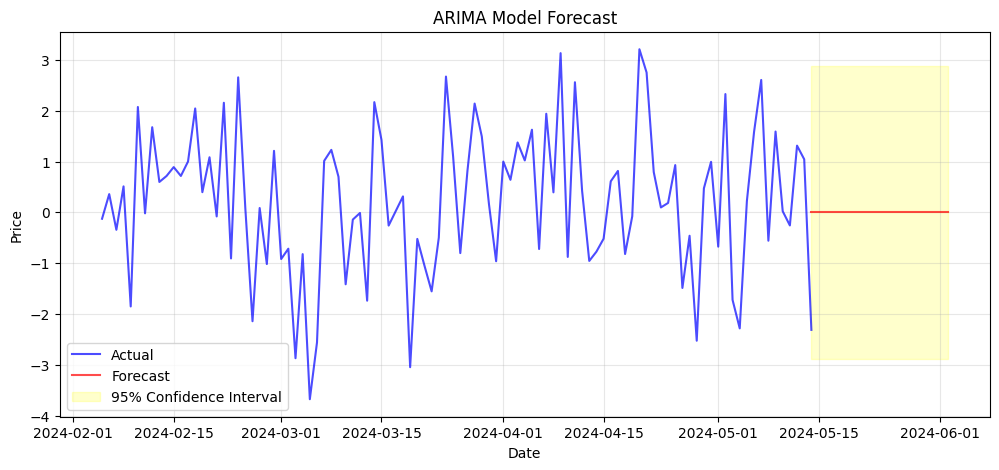

In [185]:
# plot forecast

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(actual.index, actual['Returns'], label='Actual', linewidth=1.5, alpha=0.7, color='blue')
ax.plot(forecast_index, arima_forecast, label='Forecast', linewidth=1.5, alpha=0.7, color='red')
ax.fill_between(forecast_index, confidence.iloc[:,0].values, confidence.iloc[:,1].values, alpha=0.2, color='yellow', label='95% Confidence Interval')
ax.set_title('ARIMA Model Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [211]:
# convert return forecast to price forecast

last_price = df_stock['Price'].iloc[-1]

forecast_price = last_price * np.exp(np.cumsum(arima_forecast/100))
conf_price_lo = last_price * np.exp(np.cumsum(confidence.iloc[:,0]/100))
conf_price_hi = last_price * np.exp(np.cumsum(confidence.iloc[:,1]/100))

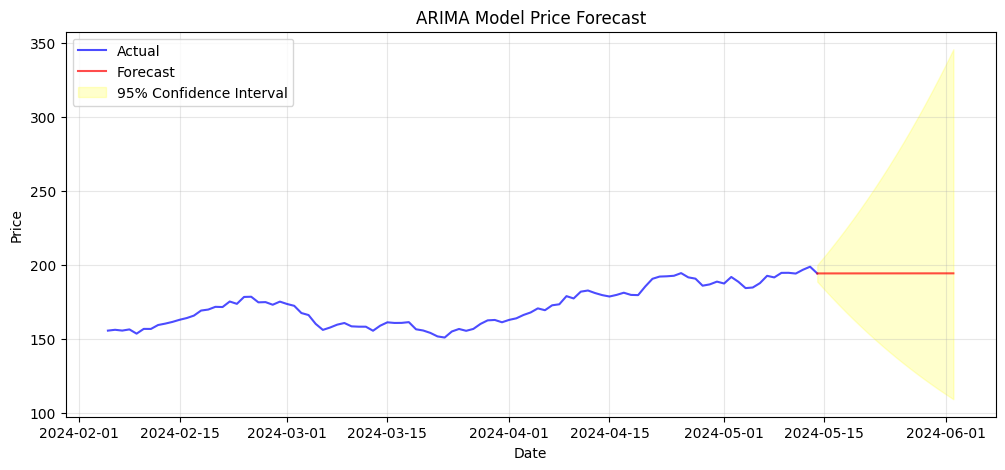

In [210]:
# plot price forecast

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(actual.index, actual['Price'], label='Actual', linewidth=1.5, alpha=0.7, color='blue')
ax.plot(forecast_index, forecast_price, label='Forecast', linewidth=1.5, alpha=0.7, color='red')
ax.fill_between(forecast_index, conf_price_lo, conf_price_hi, alpha=0.2, color='yellow', label='95% Confidence Interval')
ax.set_title('ARIMA Model Price Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

The return forecast converges to zero and has a fixed prediction interval due to its random walk nature. The price forecast ends up being about 194 for the duration of the 20 days with a widening prediction interval. As the forecast horizon increases, the uncertainty also increases, leading to a widening prediction interval.